In [1]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("EnvironmentalSustainabilityAnalysis").getOrCreate()

# Load the dataset
file_path = 'C:/Users/PMYLS/Downloads/EDUNONCORE_DATA_NATIONAL.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Handle missing values by dropping rows with missing VALUE
df_cleaned = df.na.drop(subset=["VALUE"])

# Fill missing values in MAGNITUDE and QUALIFIER with 'Unknown'
df_cleaned = df_cleaned.fillna({"MAGNITUDE": "Unknown", "QUALIFIER": "Unknown"})

# Show the schema to verify data types
df_cleaned.printSchema()

# Show the first few rows of the dataframe
df_cleaned.show()


root
 |-- INDICATOR_ID: string (nullable = true)
 |-- COUNTRY_ID: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- MAGNITUDE: string (nullable = false)
 |-- QUALIFIER: string (nullable = false)

+------------+----------+----+--------+---------+---------+
|INDICATOR_ID|COUNTRY_ID|YEAR|   VALUE|MAGNITUDE|QUALIFIER|
+------------+----------+----+--------+---------+---------+
|       20000|       ABW|2003|   597.0|  Unknown|  Unknown|
|       20000|       ABW|2004|   590.0|  Unknown|  Unknown|
|       20000|       ABW|2005|   654.0|  Unknown|  Unknown|
|       20000|       ABW|2013|   757.0|  Unknown|  Unknown|
|       20000|       AGO|1999|157782.0|  Unknown|  Unknown|
|       20000|       AGO|2007|938389.0|  Unknown|  Unknown|
|       20000|       AGO|2008|711025.0|  Unknown|  Unknown|
|       20000|       AGO|2010|663015.0|  Unknown|  NAT_EST|
|       20000|       AIA|2001|     0.0|       NA|  Unknown|
|       20000|       AIA|2002|

C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


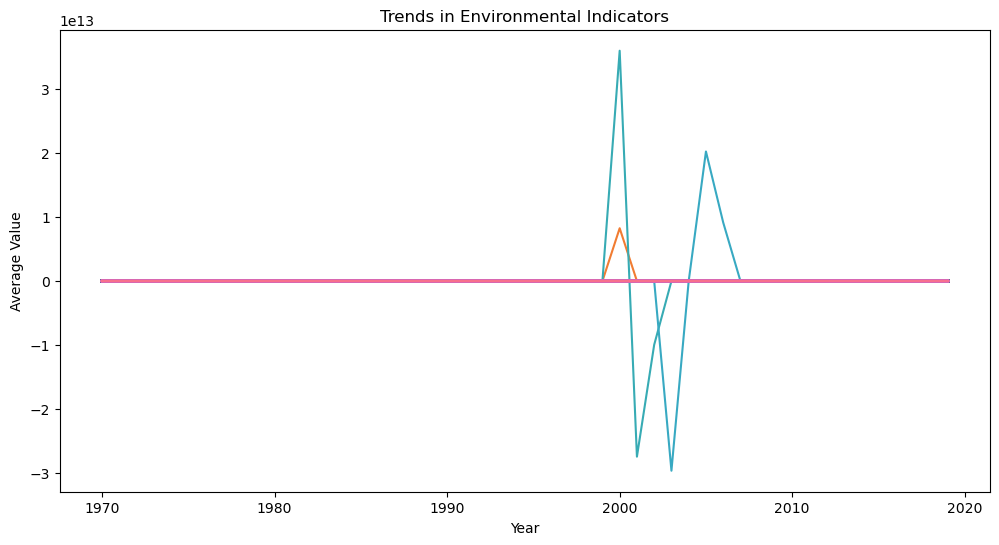

In [4]:
# Convert Spark DataFrame to Pandas DataFrame for EDA and visualization
pandas_df = df_cleaned.toPandas()

# Group by COUNTRY_ID and YEAR to see trends in VALUE
grouped_df = pandas_df.groupby(["COUNTRY_ID", "YEAR"]).agg({"VALUE": "mean"}).reset_index()

# Plot trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_df, x="YEAR", y="VALUE", hue="COUNTRY_ID", legend=None)
plt.title("Trends in Environmental Indicators")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.show()


Root Mean Squared Error (RMSE): 475515186.12467194


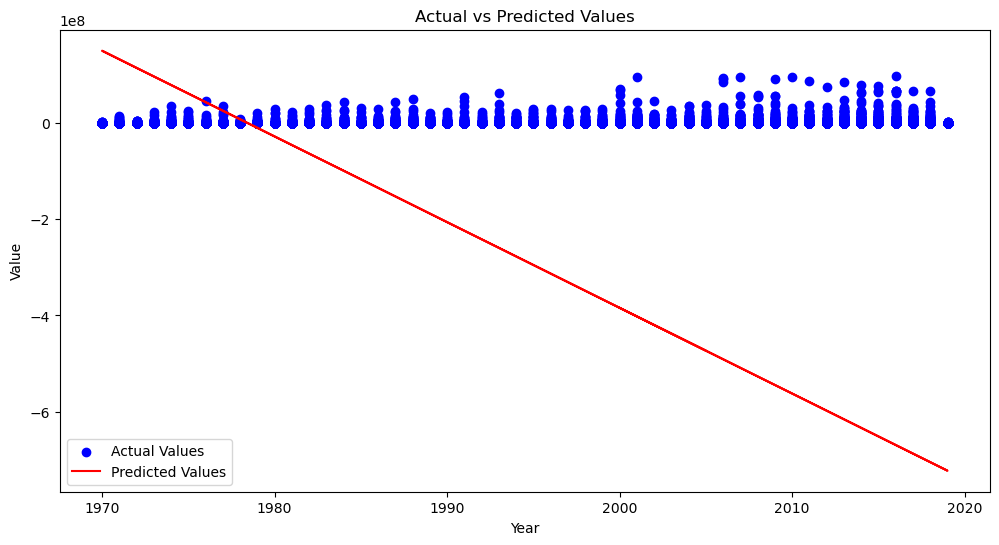

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Prepare data for machine learning
assembler = VectorAssembler(inputCols=["YEAR"], outputCol="features")
data = assembler.transform(df_cleaned)

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Initialize Linear Regression model
lr = LinearRegression(labelCol="VALUE", featuresCol="features")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="VALUE", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize the predictions
predictions_pd = predictions.select("YEAR", "VALUE", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.scatter(predictions_pd["YEAR"], predictions_pd["VALUE"], color='blue', label="Actual Values")
plt.plot(predictions_pd["YEAR"], predictions_pd["prediction"], color='red', label="Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()
